<a href="https://colab.research.google.com/github/gandhisamay/Drone-Cam-Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Semantic Segmentation - Samay Gandhi** 
## **Pytorch**

### *Check the specifications of gpu*

In [ ]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 116.6 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
%cd '/content/drive/MyDrive/Datasets /Semantic Drone Dataset'

/content/drive/MyDrive/Datasets /Semantic Drone Dataset


## *Import necessary libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
%matplotlib inline

In [ ]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms 
from torchvision import datasets
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-4

## *View the Images*

In [ ]:

images = 'dataset/semantic_drone_dataset/Original_Images'
rgb_masks = 'RGB_color_image_masks'
labels = 'dataset/semantic_drone_dataset/Labels'

image = Image.open(images + '/original_images/594.jpg')
rgb_mask = Image.open(rgb_masks + '/RGB_color_image_masks/594.png')
label = Image.open(labels + '/label_images_semantic/594.png')

fig = plt.figure(figsize=(32,32))
rows = 1
columns = 3

fig.add_subplot(rows,columns,1)
plt.imshow(image)
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows,columns,2)
plt.imshow(rgb_mask,alpha=0.9)
plt.axis('off')
plt.title("Label with RGB mask")

fig.add_subplot(rows,columns,3)
plt.imshow(label, cmap='gray')
plt.axis('off')
plt.title("Label with mask")

## *Dataset class and Dataloaders*

In [ ]:
# 0 : others - 0
# 1 : area - 1
# 9 : roof - 2
# 3 : grass - 3
# 5 : water - 4
# 15 : person - 5 
# 17 : car - 6

In [ ]:
class DroneDataset(Dataset):
    def __init__(self,images_path,labels_path):
        self.images = datasets.ImageFolder(images_path,
                                       transform=transforms.Compose([
                                          transforms.Resize((256,256)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ]))
        self.labels = datasets.ImageFolder(labels_path,transform=transforms.Compose([
                                          transforms.Grayscale(),
                                          transforms.Resize((256,256)),
                                          transforms.ToTensor()
        ]))

    def __getitem__(self,index): 
        img_output = self.labels[index][0]
        img_output = 255*img_output
        #Manipulate the label Images
        mask = np.array([[0,0],
                         [1,1],
                         [2,0],
                         [3,3],
                         [4,1],
                         [5,5],
                         [6,0],
                         [7,5],
                         [8,3],
                         [9,2],
                         [10,0],
                         [11,2],
                          [12,2],
                          [13,0],
                          [14,0],
                          [15,5],
                          [16,5],
                          [17,6],
                          [18,6],
                          [19,3],
                          [20,3],
                          [21,0],
                          [22,0],
                          [23,0]
                        ])
        for i in range(0,24):
          img_output[img_output == i] = mask[i][1]

        img_output = img_output.to(torch.int64)
        return self.images[index][0],img_output
  
    def __len__(self):
        return len(self.images)

In [ ]:
dataset = DroneDataset(images,labels)

In [ ]:
torch.unique(dataset[2][1])

tensor([0, 1, 2, 3, 5, 6])

In [ ]:
#Split the data into train and val dataset
n_val = 10

train_dataset,val_dataset = random_split(dataset,[len(dataset)-n_val,n_val],generator=torch.Generator().manual_seed(42))

In [ ]:
#Make the data_loader now so that the data is ready for training
batch_size = 4

train_loader = DataLoader(train_dataset,batch_size)
test_loader  = DataLoader(val_dataset,batch_size*2)

## *Model*

In [ ]:
#Define the CNN block now
#Defined as per the U-net Structure 
#Made some modifications too to the original structure
class DoubleCNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            out_channels
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            out_channels
        )
        self.act2 = nn.ReLU() 
    def forward(self,x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        return out

In [ ]:
class UpConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        ) 

    def forward(self,x,skip_connection):
        out = self.tconv(x)
        if out.shape != skip_connection.shape:
            out = TF.resize(out ,size=skip_connection.shape[2:])
        out = torch.cat([skip_connection,out],axis = 1)
        return out

In [ ]:
class Bottom(nn.Module):
    def __init__(self,channel=[128,256]):
        super().__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(
            in_channels=self.channel[0],
            out_channels=self.channel[1],
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            self.channel[1]
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.channel[1],
            out_channels=self.channel[1],
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            self.channel[1]
        )
        self.act2 = nn.ReLU()
        
        self.bottom = nn.Sequential(
            self.conv1,
            self.bn1,
            self.act1,
            self.conv2,
            self.bn2,
            self.act2
        )
    def forward(self,x):
#         out = self.act1(self.bn1(self.conv1(x)))
#         print("1:{}".format(out.shape))
#         out = self.act2(self.bn2(self.conv2(out)))
#         print("2:{}".format(out.shape))
        return self.bottom(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self,num_classes,filters=[16,32,64,128],input_channels=3):
        super().__init__()
        self.contract = nn.ModuleList()
        self.expand   = nn.ModuleList()                      #64 - #128 - #256 - #512 - #1024 -#512
        self.filters  = filters
        self.input_channels = input_channels
        self.num_classes = num_classes 
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        for filters in self.filters:
            self.contract.append(
                DoubleCNNBlock(
                    in_channels=input_channels,
                    out_channels=filters
                )
            )
            input_channels = filters
            
        for filters in reversed(self.filters):
            self.expand.append(
                UpConv(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            self.expand.append(
                DoubleCNNBlock(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            
        self.final = nn.Conv2d(
                    in_channels=self.filters[0],
                    out_channels=num_classes,
                    kernel_size=3,
                    padding=1,
                    stride=1
                    )
            
    def forward(self,x):
        skip_connections = []
        
        for downs in self.contract:
            out = downs(x)
            skip_connections.append(out)
            out   = self.pool(out)
            x = out
        
        bottom = Bottom()
        bottom.to(DEVICE)
        y = bottom(x)
        
        for idx in range(0,len(self.expand),2):
            skip_connection = skip_connections[len(skip_connections)-idx//2-1]
            y = self.expand[idx](y,skip_connection)
            y = self.expand[idx+1](y)
            
        return self.final(y)

In [ ]:
model = Unet(num_classes=8)
model.to(DEVICE)

Unet(
  (contract): ModuleList(
    (0): DoubleCNNBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (1): DoubleCNNBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (2): DoubleCNNBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stri

In [ ]:
def DICEloss(preds,outputs,smooth=1):
  preds = F.softmax(preds,dim=1)
  labels_one_hot = F.one_hot(outputs, num_classes = 8).permute(0,3,1,2).contiguous()
  intersection = torch.sum(preds*labels_one_hot)
  total = torch.sum(preds*preds) + torch.sum(labels_one_hot*labels_one_hot)
  return 1-((2*intersection + smooth)/(total))

In [ ]:
model = Unet(num_classes=8)
model.load_state_dict(torch.load('Only 7 classes2'))

<All keys matched successfully>

In [ ]:
model.to(DEVICE)

In [ ]:
opt  = torch.optim.Adam(model.parameters(),lr = 1e-5)

## *Training the model*

In [ ]:
#Training the model 
model.train()

num_epochs = 15
loss_per_iteration = []
iters = []

for epochs in range(1,num_epochs+1):

    loss_per_epoch = 0.0
    batch_num = 0
    for inputs,outputs in tqdm(train_loader):
        
        torch.cuda.empty_cache()
        inputs,outputs = inputs.to(DEVICE),outputs.to(DEVICE)
        preds = model(inputs)
        loss  = DICEloss(preds,outputs.squeeze(axis=1))
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_per_epoch += loss
        batch_num +=1

        #print("Batch num: {} | Dice Loss:{}".format(batch_num,loss))
    loss_per_iteration.append(loss_per_epoch)
    iters.append(epochs)
  
    print("[{}/{}] Loss : {} ".format(epochs,num_epochs,loss_per_epoch))

    #Saving the model after every epoch
    torch.save(model.state_dict(),'Only 7 classes2')
    print("Saved the model...")

  0%|          | 0/98 [00:00<?, ?it/s]

[1/15] Loss : 11.431901931762695 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[2/15] Loss : 11.335301399230957 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[3/15] Loss : 11.271146774291992 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[4/15] Loss : 11.193113327026367 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[5/15] Loss : 11.125747680664062 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[6/15] Loss : 11.060759544372559 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[7/15] Loss : 10.99058723449707 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[8/15] Loss : 10.94069766998291 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[9/15] Loss : 10.861589431762695 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[10/15] Loss : 10.810158729553223 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[11/15] Loss : 10.738924980163574 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[12/15] Loss : 10.681622505187988 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[13/15] Loss : 10.622701644897461 
Saved the model...


  0%|          | 0/98 [00:00<?, ?it/s]

[14/15] Loss : 10.55465316772461 
Saved the model...


100%|██████████| 98/98 [04:36<00:00,  2.82s/it]

[15/15] Loss : 10.499202728271484 
Saved the model...


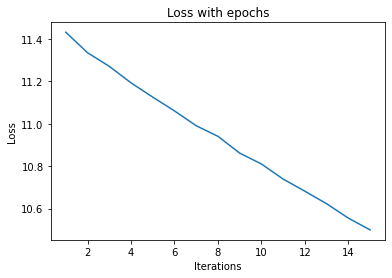

In [ ]:
plt.title('Loss with epochs')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(iters,loss_per_iteration)

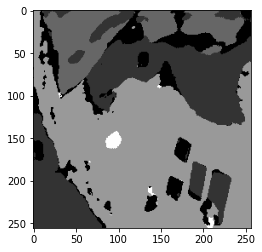

In [ ]:
plt.imshow(torch.argmax(F.softmax(model(TF.to_tensor(TF.resize(image,size=(256,256))).to(DEVICE).unsqueeze(0)),dim=1),axis=1).cpu()[0],cmap='gray')

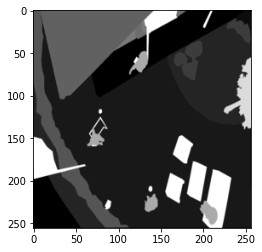

In [ ]:
plt.imshow((TF.to_tensor(TF.resize(label,size=(256,256))))[0],cmap='gray')

In [ ]:
img = torch.argmax(F.softmax(model(TF.to_tensor(TF.resize(image,size=(256,256))).to(DEVICE).unsqueeze(0)),dim=1),axis=1)

In [ ]:
color_array = np.array([[0,0,0],
               [128,64,128],
               [70,70,70],
               [0,102,0],
               [28,42,168],
               [125,22,96],
               [9,143,150]])
print(color_array)

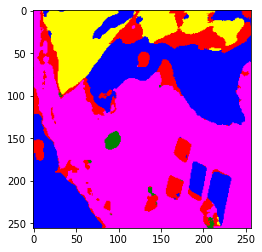

In [ ]:
from skimage.color import label2rgb
plt.imshow(label2rgb(img.view(256,256).detach().cpu().numpy()))